In [1]:
import torch
from torch import nn
from torch.optim import Adam
from torchsummary import summary
import librosa
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import LabelEncoder
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import os
from skimage.transform import resize

device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
data_df = pd.read_csv("data/files_paths.csv")

In [3]:
data_df.sample(5)

,FilePath,Class
2770,./Dataset/Bander_Balilah/bander_noiseRed_034.wav,Bander_Balilah
4963,./Dataset/AbdulRahman_Alsudais/alsudais_167.wav,AbdulRahman_Alsudais
1204,./Dataset/Maher_Almuaiqly/Maher_noiseRed_120.wav,Maher_Almuaiqly
5334,./Dataset/AbdulRahman_Alsudais/السديس_107.wav,AbdulRahman_Alsudais
6268,./Dataset/Abdullah_Albuaijan/Abdullah_427.wav,Abdullah_Albuaijan


In [4]:
print(data_df["Class"].unique())
print(len(data_df["Class"].unique()))


['Mohammed_Aluhaidan' 'Yasser_Aldossary' 'Maher_Almuaiqly'
 'Nasser_Alqutami' 'AbdulBari_Althubaity' 'Bander_Balilah'
 'Ali_Alhothaify' 'Saud_Alshuraim' 'Mohammed_Ayoub' 'AbdulRahman_Alsudais'
 'Saad_Alghamdi' 'Abdullah_Albuaijan']
12


In [5]:
data_df["FilePath"] = 'data/Dataset'+data_df["FilePath"].str[1:]

data_df.head()

,FilePath,Class
0,data/Dataset/Dataset/Mohammed_Aluhaidan/lohaid...,Mohammed_Aluhaidan
1,data/Dataset/Dataset/Mohammed_Aluhaidan/lohaid...,Mohammed_Aluhaidan
2,data/Dataset/Dataset/Mohammed_Aluhaidan/lohaid...,Mohammed_Aluhaidan
3,data/Dataset/Dataset/Mohammed_Aluhaidan/lohaid...,Mohammed_Aluhaidan
4,data/Dataset/Dataset/Mohammed_Aluhaidan/lohaid...,Mohammed_Aluhaidan


In [6]:
data_df['FilePath'].iloc[2]

'data/Dataset/Dataset/Mohammed_Aluhaidan/lohaidan_401.wav'

Class distribution:  Class
Saud_Alshuraim          696
Saad_Alghamdi           688
AbdulRahman_Alsudais    648
Yasser_Aldossary        576
Ali_Alhothaify          576
Bander_Balilah          576
Maher_Almuaiqly         576
Abdullah_Albuaijan      504
Mohammed_Ayoub          480
Nasser_Alqutami         456
AbdulBari_Althubaity    456
Mohammed_Aluhaidan      455
Name: count, dtype: int64
Data shape:  (6687, 2) 



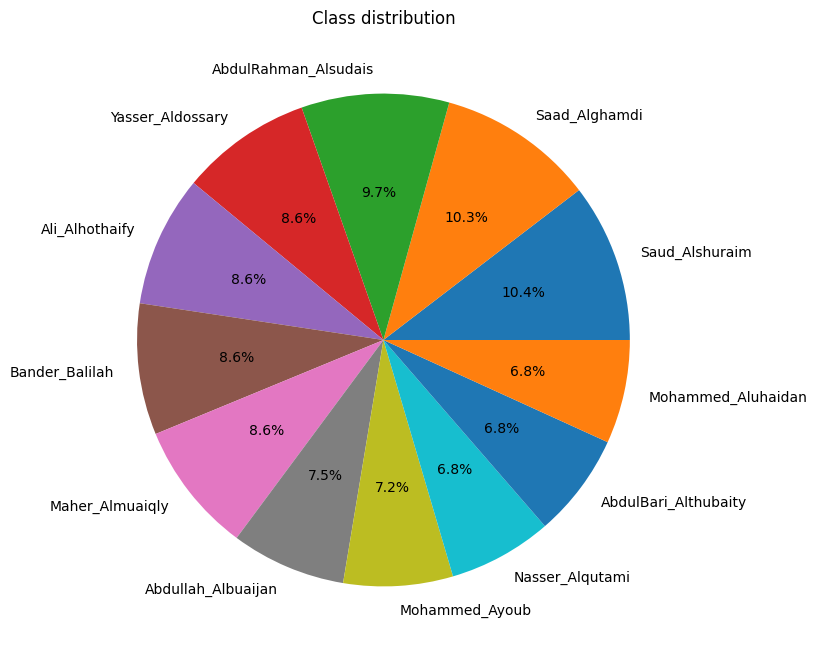

In [7]:
print("Class distribution: ", data_df["Class"].value_counts())
print("Data shape: ", data_df.shape, "\n")

plt.figure(figsize=(8,8))

plt.pie(data_df["Class"].value_counts(),labels=data_df["Class"].value_counts().index, autopct='%1.1f%%')

plt.title("Class distribution")
plt.show()

In [8]:
label_encoder = LabelEncoder()
data_df["Class"] = label_encoder.fit_transform(data_df["Class"])

train = data_df.sample(frac=0.7, random_state = 7)
test = data_df.drop(train.index)

val = test.sample(frac=0.5, random_state = 7)
test = test.drop(val.index)

print("Train shape: ", train.shape)
print("Val shape: ", val.shape)
print("Test shape: ", test.shape)

Train shape:  (4681, 2)
Val shape:  (1003, 2)
Test shape:  (1003, 2)


In [9]:
class CustomAudioDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe
        self.labels = torch.Tensor(list(dataframe["Class"])).type(torch.LongTensor).to(device)
        self.audios = [torch.Tensor(self.get_spectrogram(path)).type(torch.FloatTensor) for path in dataframe['FilePath']]

    def __len__(self):
        return self.dataframe.shape[0]

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx, 0]
        label = torch.Tensor(self.labels[idx]).to(device)
        audio = (self.audios[idx]).unsqueeze(0).to(device)
        return audio, label

    def get_spectrogram(self, file_path):
        sr = 22050
        duration = 5
        img_height = 128
        img_width = 256

        signal, sr = librosa.load(file_path, sr=sr, duration=duration)

        spec = librosa.feature.melspectrogram(y=signal, sr=sr, n_fft=2048, hop_length=512, n_mels=128)
        spec_db = librosa.power_to_db(spec, ref=np.max)

        spec_resized = librosa.util.fix_length(spec_db, size = duration * sr // 512 + 1)
        spec_resized = resize(spec_resized, (img_height, img_width), anti_aliasing=True)

        return spec_resized

In [10]:
train_dataset = CustomAudioDataset(dataframe=train)
val_dataset = CustomAudioDataset(dataframe=val)
test_dataset = CustomAudioDataset(dataframe=test)

In [11]:
LR = 1e-4
BATCH_SIZE = 16
EPOCHS = 15

In [12]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [13]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pooling = nn.MaxPool2d(2,2)
        self.relu = nn.ReLU()

        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(64*16*32, 4096)
        self.linear2 = nn.Linear(4096, 1024)
        self.linear3 = nn.Linear(1024, 512)
        self.output = nn.Linear(512, len(data_df['Class'].unique()))

        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.conv1(x)
        x = self.pooling(x)
        x = self.conv2(x)
        x = self.pooling(x)
        x = self.conv3(x)
        x = self.pooling(x)
        x = self.relu(x)

        x = x.view(x.size(0), -1)

        x = self.flatten(x)
        x = self.linear1(x)
        x = self.dropout(x)

        x = self.linear2(x)
        x = self.dropout(x)

        x = self.linear3(x)
        x = self.dropout(x)

        x = self.output(x)

        return x

In [14]:
model = Net().to(device)

print(model)

Net(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pooling): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=32768, out_features=4096, bias=True)
  (linear2): Linear(in_features=4096, out_features=1024, bias=True)
  (linear3): Linear(in_features=1024, out_features=512, bias=True)
  (output): Linear(in_features=512, out_features=12, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [15]:
summary(model, (1,128, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 128, 256]             160
         MaxPool2d-2          [-1, 16, 64, 128]               0
            Conv2d-3          [-1, 32, 64, 128]           4,640
         MaxPool2d-4           [-1, 32, 32, 64]               0
            Conv2d-5           [-1, 64, 32, 64]          18,496
         MaxPool2d-6           [-1, 64, 16, 32]               0
              ReLU-7           [-1, 64, 16, 32]               0
           Flatten-8                [-1, 32768]               0
            Linear-9                 [-1, 4096]     134,221,824
          Dropout-10                 [-1, 4096]               0
           Linear-11                 [-1, 1024]       4,195,328
          Dropout-12                 [-1, 1024]               0
           Linear-13                  [-1, 512]         524,800
          Dropout-14                  [

In [16]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=LR)

In [17]:
total_loss_train_plot = []
total_loss_validation_plot = []
total_acc_train_plot = []
total_acc_validation_plot = []
start_time = time.time()

for epoch in range(EPOCHS):
    total_acc_train = 0
    total_acc_validation = 0
    total_loss_train = 0
    total_loss_validation = 0

    for inputs, labels in train_loader:
        outputs = model(inputs)
        train_loss = criterion(outputs, labels)
        total_loss_train += train_loss.item()
        train_loss.backward()

        train_acc = (torch.argmax(outputs, axis = 1) == labels).sum().item()
        total_acc_train += train_acc
        optimizer.step()
        optimizer.zero_grad()

    with torch.no_grad():
        for inputs, labels in val_loader:
          outputs = model(inputs)
          val_loss = criterion(outputs, labels)
          total_loss_validation += val_loss.item()

          val_acc = (torch.argmax(outputs, axis = 1) == labels).sum().item()
          total_acc_validation += val_acc

    total_loss_train_plot.append(round(total_loss_train / 1000, 4))
    total_loss_validation_plot.append(round(total_loss_validation / 1000, 4))
    total_acc_train_plot.append(round(total_acc_train / train_dataset.__len__()*100, 4))
    total_acc_validation_plot.append(round(total_acc_validation / val_dataset.__len__()*10, 4))

    print(f"Epoch {epoch+1}/{EPOCHS} \n\t Train Loss: {round(total_loss_train / 100, 4)}, Train Accuracy: {round(total_acc_train / train_dataset.__len__()*100, 4)}%\n\t Validation Loss:{round(total_loss_validation / 100, 4)}, Validation Accuracy: {round(total_acc_validation / val_dataset.__len__()*100, 4)}%\n\n")

print("Training time is: ", round(time.time()-start_time, 4), " seconds")

Epoch 1/15 
	 Train Loss: 9.9536, Train Accuracy: 37.9192%
	 Validation Loss:0.5808, Validation Accuracy: 69.3918%


Epoch 2/15 
	 Train Loss: 1.9536, Train Accuracy: 79.1498%
	 Validation Loss:0.2954, Validation Accuracy: 86.0419%


Epoch 3/15 
	 Train Loss: 1.0982, Train Accuracy: 88.4854%
	 Validation Loss:0.2627, Validation Accuracy: 86.341%


Epoch 4/15 
	 Train Loss: 0.7721, Train Accuracy: 91.8821%
	 Validation Loss:0.2232, Validation Accuracy: 89.8305%


Epoch 5/15 
	 Train Loss: 0.6269, Train Accuracy: 93.5484%
	 Validation Loss:0.1501, Validation Accuracy: 93.6191%


Epoch 6/15 
	 Train Loss: 0.5176, Train Accuracy: 94.1252%
	 Validation Loss:0.1485, Validation Accuracy: 93.7188%


Epoch 7/15 
	 Train Loss: 0.5235, Train Accuracy: 94.4456%
	 Validation Loss:0.2186, Validation Accuracy: 92.2233%


Epoch 8/15 
	 Train Loss: 0.394, Train Accuracy: 96.0479%
	 Validation Loss:0.1992, Validation Accuracy: 90.9272%


Epoch 9/15 
	 Train Loss: 0.4982, Train Accuracy: 94.8088%
	 Valid

In [21]:
with torch.no_grad():
    total_loss_test = 0
    total_acc_test = 0
    for inputs, labels in test_loader:
        predictions = model(inputs)
        acc = (torch.argmax(predictions, axis=1) == labels).sum().item()

        total_acc_test += acc
print(f"Test Accuracy: {round(total_acc_test/test_dataset.__len__()*100, 4)}%")

Test Accuracy: 93.8185%


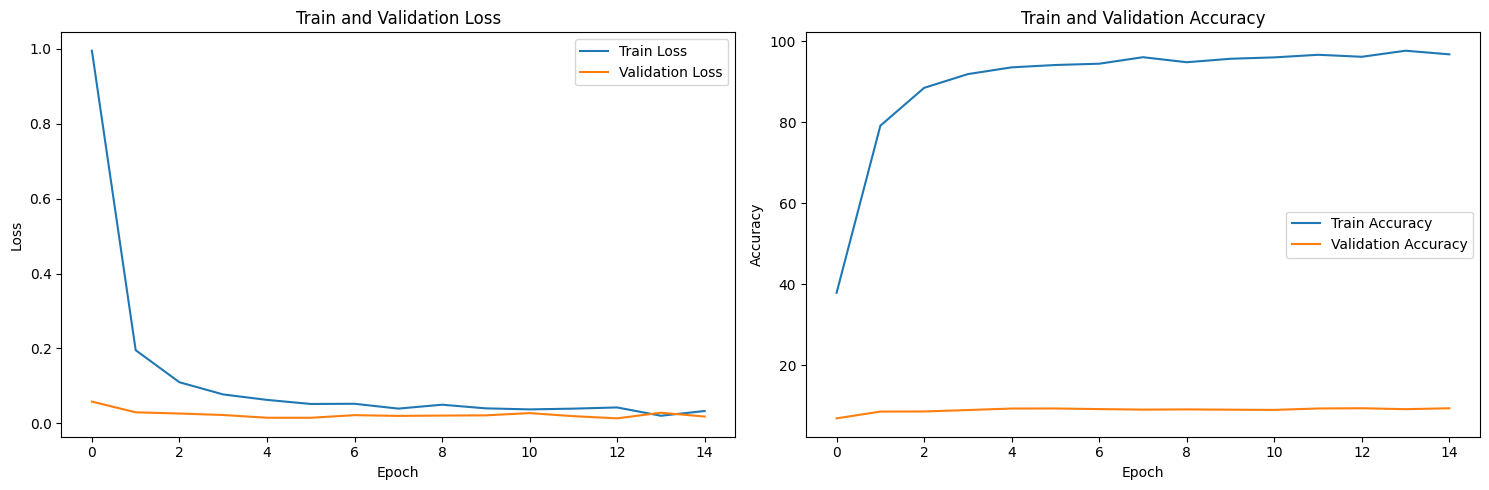

In [20]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axs[0].plot(total_loss_train_plot, label="Train Loss")
axs[0].plot(total_loss_validation_plot, label="Validation Loss")
axs[0].set_title("Train and Validation Loss")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Loss")
axs[0].legend()

axs[1].plot(total_acc_train_plot, label="Train Accuracy")
axs[1].plot(total_acc_validation_plot, label="Validation Accuracy")
axs[1].set_title("Train and Validation Accuracy")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Accuracy")
axs[1].legend()

plt.tight_layout()
plt.show()

In [22]:
torch.save(model.state_dict(), "model/audio_classification_model.pth")

In [26]:
model_load = Net().to(device)

model_load.load_state_dict(torch.load("model/audio_classification_model.pth"))
model_load.eval()

Net(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pooling): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=32768, out_features=4096, bias=True)
  (linear2): Linear(in_features=4096, out_features=1024, bias=True)
  (linear3): Linear(in_features=1024, out_features=512, bias=True)
  (output): Linear(in_features=512, out_features=12, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [27]:
with torch.no_grad():
    total_loss_test = 0
    total_acc_test = 0
    for inputs, labels in test_loader:
        predictions = model_load(inputs)
        acc = (torch.argmax(predictions, axis=1) == labels).sum().item()

        total_acc_test += acc
print(f"Test Accuracy: {round(total_acc_test/test_dataset.__len__()*100, 4)}%")

Test Accuracy: 95.1147%
